# 🏋️‍♀️Fitness identifier Iteratie 2

<h2 style="font-size:20px; color:#3B82F6;">Inleiding</h2>

in dit notebook wil een paar dingen gaan testen: ik maakte bij me eerste iteratie de fout dat ik mijn AI-model ging testen met afbeeldingen waarmee ik het model ook getraind had, dus wil ik nu andere afbeeldingen gaan gebruiken om een meer realistische beeld te krijgen. Verder wil ik nu ook met een kleinere subset gaan itereren, zodat ik niet lang moet wachten tijdens het trainen. Als laatste wil ik kijken of ik misschien met een hogere aantal numworkers kan trainen

In [20]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


import pandas, platform, os
import torch as T 
import torchvision as V
import pytorch_lightning as L
import torch.utils.data as D
import torchmetrics as M
import matplotlib.pyplot as plt




data_path = "dataset/data"
inference_path = "reference/classification_image--clothing/dataset/inference2"

T.manual_seed(42)

print("Versions: python", platform.python_version(), "| torch", T.__version__, "| torchvision", V.__version__, "| pytorch_lightning", L.__version__)


Versions: python 3.13.7 | torch 2.9.0+cpu | torchvision 0.24.0+cpu | pytorch_lightning 2.5.5


In [21]:
import os

data_path = r"C:\Users\yusuf\OneDrive\Documenten\HBO ICT\AlleGit - Github\fitness-exercise-identifier\reference\classification_image--clothing\dataset\data"

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    if os.path.isdir(folder_path):
        count = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{folder}: {count} foto's")


cable_flyes: 200 foto's
incline_benchpress: 143 foto's
machine_pulldown: 210 foto's
pullup: 270 foto's
romanian_deadlift: 280 foto's
squats: 336 foto's


In [22]:
pretrained_model = V.models.resnet18(weights="DEFAULT")

In [23]:
# Prepare the dataset
image_size = (244, 244)

transform = V.transforms.Compose([
    V.transforms.Resize(image_size),
    V.transforms.ToTensor(),
])

dataset = V.datasets.ImageFolder(data_path, transform=transform)
classes = dataset.classes
print("Created an image dataset for classes:", classes)

# === ⬇️ NIEUW TOEGEVOEGD: subset van 15% maken voor snellere training ===
subset_percentage = 0.15  # gebruik 10–15% voor snelle iteraties
subset_size = int(len(dataset) * subset_percentage)
remaining_size = len(dataset) - subset_size

subset_dataset, _ = T.utils.data.random_split(dataset, [subset_size, remaining_size])
dataset = subset_dataset  # overschrijft 'dataset' zodat DataModule dit gebruikt

print(f"Subset geselecteerd: {len(dataset)} afbeeldingen van totaal {len(classes)} klassen.")
# === ⬆️ EINDE NIEUWE CODE ===


Created an image dataset for classes: ['cable_flyes', 'incline_benchpress', 'machine_pulldown', 'pullup', 'romanian_deadlift', 'squats']
Subset geselecteerd: 215 afbeeldingen van totaal 6 klassen.


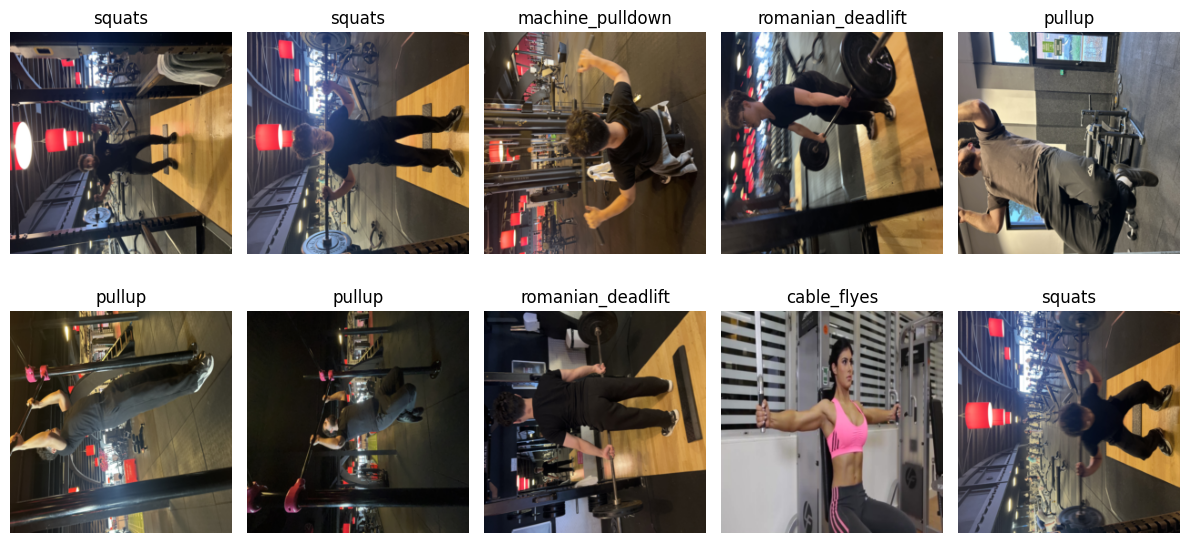

In [24]:
sample_size = 10
indices = T.randperm(len(dataset))[:sample_size]
sampled_images = [dataset[i][0] for i in indices]
sampled_labels = [dataset[i][1] for i in indices]
fig, axes = plt.subplots(nrows=int(sample_size/5), ncols=5, figsize=(12, 6))
for i, (image, label) in enumerate(zip(sampled_images, sampled_labels)):
    ax = axes[i // 5, i % 5]
    ax.imshow(image.permute(1, 2, 0).numpy())
    ax.set_title(classes[label])
    ax.axis('off')
plt.tight_layout()

In [25]:
class DataModule(L.LightningDataModule):
    def __init__(self, data, split=[.7, .2, .1], batch_size=16, num_workers=0):
        super().__init__()
        self.data = data
        self.split = split
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform

    def setup(self, stage=None):
        self.train, self.val, self.test = D.random_split(self.data, self.split)

    def train_dataloader(self):
        return D.DataLoader(self.train, shuffle=True, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def val_dataloader(self):
        return D.DataLoader(self.val, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def test_dataloader(self):
        return D.DataLoader(self.test, batch_size=self.batch_size, num_workers=self.num_workers)


datamodule = DataModule(dataset)
datamodule.setup()

In [26]:
class ImageClassifierModel(L.LightningModule):
    def __init__(self, pretrained_model, num_classes, freeze_layers=True):
        super().__init__()
        self.num_classes = num_classes
        self.model = pretrained_model
        if freeze_layers:
            for param in self.model.parameters(): 
                param.requires_grad = False
        self.model.fc = T.nn.Linear(self.model.fc.in_features, num_classes)
        self.criterion = T.nn.CrossEntropyLoss()
        self.accuracy = M.Accuracy(task="multiclass", num_classes=self.num_classes, average="none")
        self.precision = M.Precision(task="multiclass", num_classes=self.num_classes, average="none")
        self.recall = M.Recall(task="multiclass", num_classes=self.num_classes, average="none") 
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        return T.optim.Adam(self.parameters(), lr=0.002) 

    def training_step(self, batch):
        x, y = batch
        logits = self(x)
        return self.criterion(logits, y)
    
    def validation_step(self, batch):
        x, y = batch
        logits = self(x)
        self.log("val_loss", self.criterion(logits, y))

    def test_step(self, batch):
        x, y = batch
        logits = self(x)
        preds = logits.argmax(dim=1)
        self.accuracy(preds, y)
        self.precision(preds, y)
        self.recall(preds, y)
    
    def predict_step(self, batch):
        x, y = batch
        logits = self(x)
        return logits

    def on_test_epoch_end(self):
        accuracy = self.accuracy.compute()
        precision = self.precision.compute()
        recall = self.recall.compute()
        for i in range(self.num_classes):
            self.log("test_accuracy_class_" + str(i), accuracy[i])
            self.log("test_precision_class_" + str(i), precision[i])
            self.log("test_recall_class_" + str(i), recall[i])


model = ImageClassifierModel(pretrained_model, num_classes=len(classes))

In [27]:
logger = L.loggers.CSVLogger(save_dir=".")
stop = L.callbacks.early_stopping.EarlyStopping(monitor="val_loss", mode="min")
trainer = L.Trainer(max_epochs=-1, logger=logger, callbacks=[stop])
trainer.fit(model, datamodule=datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | ResNet              | 11.2 M | train
1 | criterion | CrossEntropyLoss    | 0      | train
2 | accuracy  | MulticlassAccuracy  | 0      | train
3 | precision | MulticlassPrecision | 0      | train
4 | recall    | MulticlassRecall    | 0      | train
----------------------------------------------------------
3.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.718    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\yusuf\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


c:\Users\yusuf\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\yusuf\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 48: 100%|██████████| 10/10 [00:21<00:00,  0.47it/s, v_num=40]


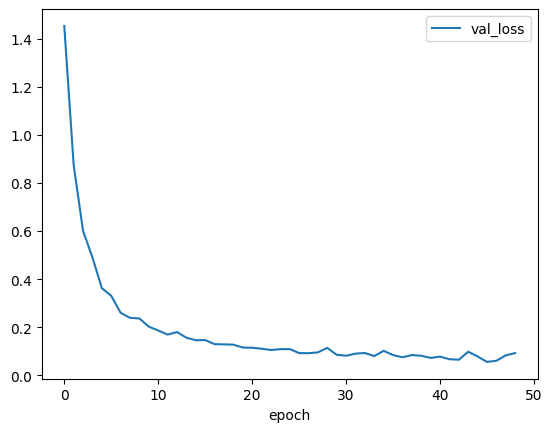

In [28]:
metrics = pandas.read_csv(os.path.join(trainer.log_dir, "metrics.csv"))
loss_metrics = metrics[["epoch", "val_loss"]].set_index("epoch")
plot = loss_metrics.plot()

In [29]:
scores = trainer.test(model, datamodule=datamodule, verbose=False)
accuracies = [scores[0]["test_accuracy_class_" + str(i)] for i in range(len(classes))]
precisions = [scores[0]["test_precision_class_" + str(i)] for i in range(len(classes))]
recalls = [scores[0]["test_recall_class_" + str(i)] for i in range(len(classes))]
df = pandas.DataFrame({"class": classes, "accuracy": accuracies, "precision": precisions, "recall": recalls}).set_index("class")
df

c:\Users\yusuf\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


,accuracy,precision,recall
class,,,
cable_flyes,0.0,0.0,0.0
incline_benchpress,1.0,1.0,1.0
machine_pulldown,1.0,1.0,1.0
pullup,1.0,1.0,1.0
romanian_deadlift,1.0,1.0,1.0
squats,1.0,1.0,1.0


In [31]:
inference_folder = V.datasets.ImageFolder(inference_path, transform=transform)
inference_dataloader = D.DataLoader(inference_folder, batch_size=32, num_workers=int(os.cpu_count()/2), persistent_workers=True)
preds = trainer.predict(model, dataloaders=inference_dataloader)

Predicting DataLoader 0: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


IndexError: index 50 is out of bounds for axis 0 with size 50

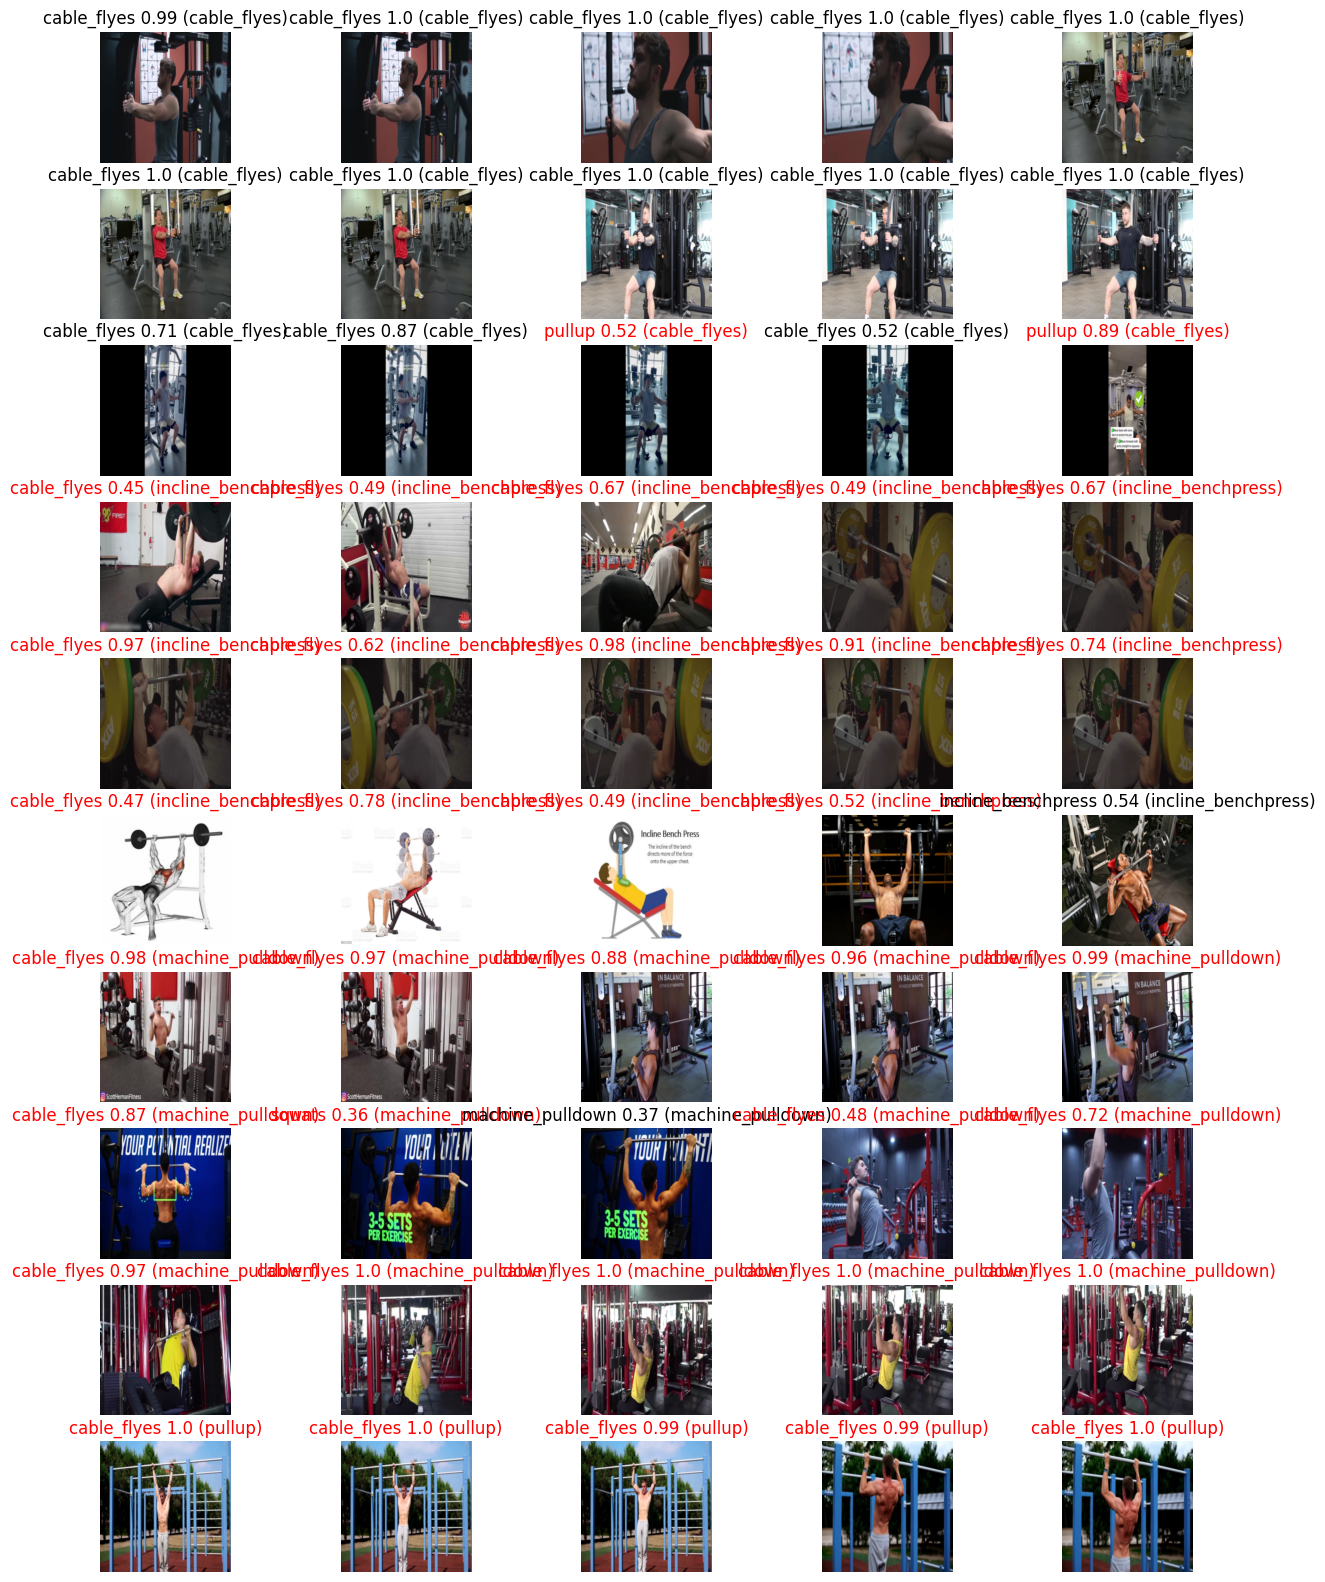

In [32]:
predictions = T.cat(preds)
images = T.cat([x for x, y in inference_dataloader])
labels = T.cat([y for x, y in inference_dataloader])

fig, axs = plt.subplots(10, 5, figsize=(15, 20))
axs = axs.flatten()
for i, (image, truth, prediction) in enumerate(zip(images, labels, predictions)):
    probabilities = T.softmax(prediction, dim=0)
    pred_class = T.argmax(probabilities)
    pred_prob = probabilities[pred_class].item()
    pred_label = classes[pred_class]
    truth_label = classes[truth.item()]
    axs[i].imshow(image.permute(1, 2, 0).numpy())
    axs[i].set_title(pred_label + " " + str(round(pred_prob,2)) + " ("+ truth_label+")", color="red" if pred_label != truth_label else "black")
    axs[i].axis("off")
plt.tight_layout()
plt.show()